# Full MICADO focal plane spectroscopic trace simulations

This notebook can be found in the [MICADO package on the IRDB Github repository](https://github.com/astronomyk/irdb/blob/master/MICADO/docs/static/)

This example is a biggun'. And it will take **upwards of half an hour** to compute depending on your hardware.
What we are doing here is using ScopeSim to project the full spectroscopic trace pattern of two point sources (a binary star system) after they have passed through the full optical system (atmosphere --> detector) onto the MICADO detector array.

This type of simulation is directed towards the team developing the data reduction pipeline. 
That said, there may be other users who would like to have a full readout of the MICADO detectors in this configuration.
It should be noted that ScopeSim **does not** provide any kind of reduction functionality. 
It is therefore up to the user to reduce and analyse their own spectra derived from these simulations.
A more user-friendly spectroscopy option is provided with the ``MICADO_Sci`` package (see the previous example notebook)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
import scopesim_templates as sim_tp

%matplotlib inline
%config Completer.use_jedi = False

The normal setup. This time using the ``MICADO`` package instead of the ``MICADO_Sci`` package.

In [2]:
sim.server.database.download_package(["locations/Armazones.zip",
                                      "telescopes/ELT.zip",
                                      "instruments/MICADO.zip"])

['F:\\temp\\scopesim_fdr_notebooks\\Armazones.zip',
 'F:\\temp\\scopesim_fdr_notebooks\\ELT.zip',
 'F:\\temp\\scopesim_fdr_notebooks\\MICADO.zip']

### Set up source

A simple object, the binary star system, can be created with the ``stars`` function in the ``scopesim_templates.basic.stars`` submodule. 
Our binary system consists of two stars with similar spectral types seperated by 200 mas. 
Each star is located 0.1 arcsec either side of the centre of the field of view.
The stars are both 18 ABmags in the Ks filter.

We redshift one of stars to induce a shift in the spectrum, that we will hopefully recover from the final simulated image.
This is visible in the right plot below.

In [48]:
stars = sim_tp.basic.stars.stars(filter_name="Ks", amplitudes=[18,18]*u.ABmag, 
                                 spec_types=["A0V", "A1V"], x=[-0.1, 0.1], y=[0, 0])
stars.spectra[1].z = 0.01

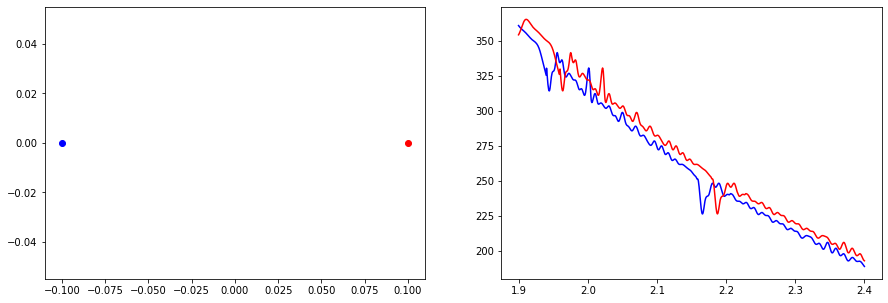

In [49]:
plt.figure(figsize=(15,5))
wave = np.linspace(1.9, 2.4, 1001) * u.um
for i, c in zip([0, 1], "br"):
    plt.subplot(121)
    plt.scatter(stars.fields[0]["x"][i], stars.fields[0]["y"][i], c=c)
    plt.subplot(122)
    plt.plot(wave, stars.spectra[i](wave), c=c)

### Set up MICADO in SPEC mode, 3 arcsec slit and HK filter

There are three spectroscopy modes available in the ``MICADO`` package, each uses a different slit:

- ``SPEC_3000x20``: Short and narrow, with a 20mas slit that is 3 arcsec long
- ``SPEC_3000x50``: Short and fat, with a 50mas slit that is 3 arcsec long
- ``SPEC_15000x50``: Long and fat, with a 50mas slit that is 15 arcsec long

For the sake of this example we will use the short and fat slit, or 3 arcsec by 50 mas.

The default filter in the spectroscopy modes is the ``Spec_HK`` filter. The other spectroscopy specific filter is names ``Spec_IJ``. It is however possible to use any other filter in any of the three wheels. Different filters can be selected using the bang-string keywords: ``"!OBS.filter_name_fw1"`` for filter wheel 1, ``"!OBS.filter_name_fw2"`` for filter wheel 2, and ``"!OBS.filter_name_pupil"`` for the pupil wheel. 

In [50]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "SPEC_3000x50"])
cmd["!OBS.filter_name_fw1"] = "Spec_HK"
cmd["!OBS.filter_name_fw2"] = "blank"
cmd["!OBS.filter_name_pupil"] = "blank"

cmd["!OBS.dit"] = 600     # [s]

Unfortunately the only way to see which filters are available is to either look in the instrument package folder in the working directory, or by initialising the ``OpticalTrain`` object and then looking at the contents of each filter wheel. This is done with the following command:
```
micado["filter_wheel_1"].data["names"]
```
for each of ``filter_wheel_1``, ``filter_wheel_2``, and ``pupil_wheel``.

Once we've set which filter we want to use, we can generate the optical model of MICADO.

The purpose of this example is to show the trace pattern of MICADO's long slit spectrograph on the focal plane. 
We therefore need to turn off the detector window and turn on the full detector array.
This is done be setting the ``include`` property of the relevant ``Effect`` objects to ``True`` or ``False``.

To find the name of any ``Effect`` in the optical model, call:
```
micado.effects
```

In [51]:
micado = sim.OpticalTrain(cmd)

micado["full_detector_array"].include = True
micado["detector_window"].include = False

Finally we are set and can simulate the observation of out binary star system

**WARNING: over 25000 spectral slices must be created and observed to run this simulation.** Please expect this to take on the order of 30 minutes to complete (hardware dependent). The best strategy would be to create a script with the commands from this notebook and execute it in the background. Also, save as much of the simulation to disk as possible to avoid wasting execution time.

In [52]:
micado.observe(stars)

Generated 12624 headers from <SpectralTrace> "list of spectral order trace geometry on the focal plane" : [1.93, 2.46]um : Ext 2 : Aperture 0 : ImagePlane 0
Generated 12415 headers from <SpectralTrace> "list of spectral order trace geometry on the focal plane" : [1.45, 1.85]um : Ext 3 : Aperture 0 : ImagePlane 0
Generated 832 headers from <SpectralTrace> "list of spectral order trace geometry on the focal plane" : [1.16, 1.48]um : Ext 4 : Aperture 0 : ImagePlane 0
Preparing 25871 FieldOfViews


We can check that the ``observe`` command ran successfully by looking inside the ``MICADO`` optical model.
The resulting normalised flux map in units of ph s-1 pixel-1 can be found in the first entry of the ``image_planes`` attribute of the optical model, in the form of a ``fits.HDUList`` object.
If the size of the data image is ~12000x12000, then the simulation has been run successfully.

**Note:** this image is the "perfect" image of the source. It contains all contaminating flux (atmosphere, telescope greybody emission, etc) but has not had the poisson noise effects and detector read noise effects applied to it.
It is still however useful to keep this image as a sanity check - i.e. that the expected flux levels are indeed seen at the detector plane.

We can save this intermediate image using the standard ``fits.HDUList`` functionality, i.e. the ``writeto`` method:

In [53]:
print(micado.image_planes[0].data.shape)
micado.image_planes[0].hdu.writeto("micado_spec_focal_plane_flux_map.fits", overwrite=True)

(12609, 12982)


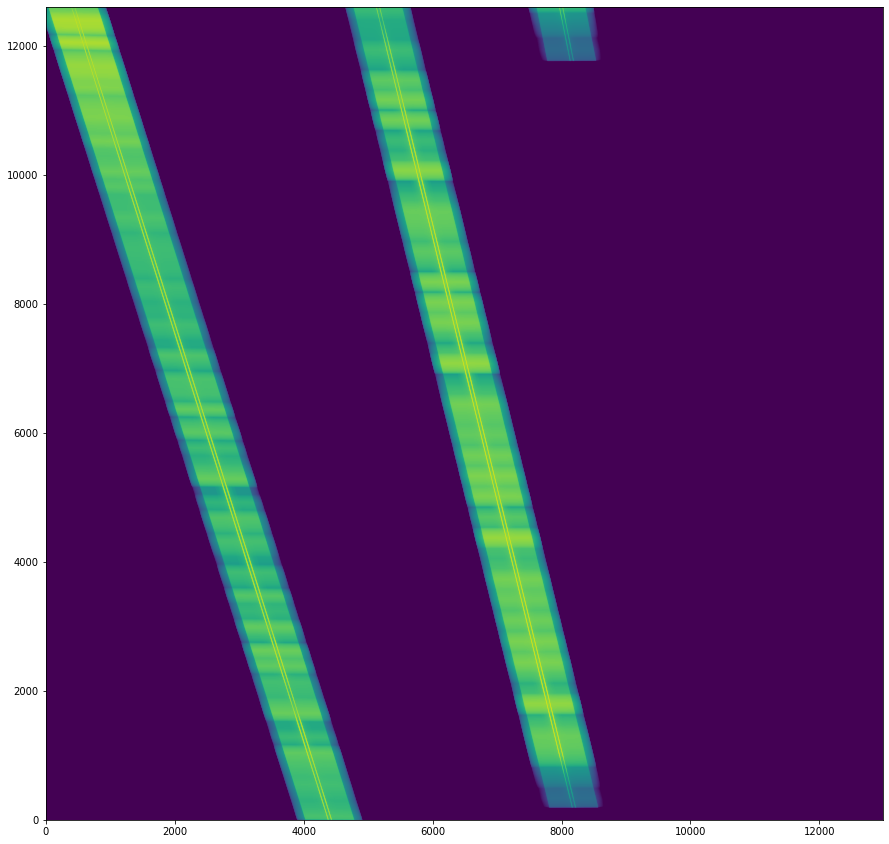

In [54]:
im = micado.image_planes[0].data
im[im<1e-7] = 1e-7

plt.figure(figsize=(15, 15))
plt.imshow(im, origin="lower", norm=LogNorm())

The above image shows the flux distribution of the three spectral traces for the ``Spec_HK`` filter over the full focal plane of MICADO.
To convert these into individual detector read out frames, we still need to call ``micado.readout``.
The final output file will be a FITS file containing 10 ``HDU``s.
The Primary HDU (index 0) contains meta data about the simulation.
HDUs 1-9 contain the raw images from each detector in the MICADO detector array, including all known detector characterists (RON, ACN, Dark current, linearity effects, dead pixels, etc)

Don't forget to save the output image to disk.

In [55]:
hdus = micado.readout(filename="micado_spec_detector_readout.fits", overwrite=True)

Becasue the MICADO detector array numbering scheme does not follow the matplotlib LRTB scheme, we cannot simply plot all the detector images in a standard ``for`` loop.

We can visualise the detector numbering scheme by calling the ``plot`` function of the ``full_detector_array`` ``Effect`` object:

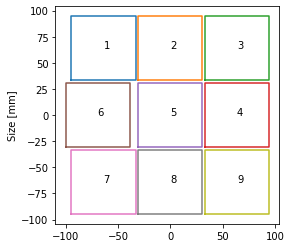

In [56]:
micado["full_detector_array"].plot()
plt.show()

Below we have the raw output images from the 9 MICADO detectors. Note the slight shift in the 6th detector.
The right 3 detectors recieve no flux projected through the slit when the Spec_HK filter is used.
The patterns visible on these detectors are due to the noise characteristics.
They are identical because ScopeSim resets the numpy random seed for each operation. 
This reset operation could be turned off (``micado.cmds[!"SIM.random.seed"] = None``) in order to get more realistic noise proerties.


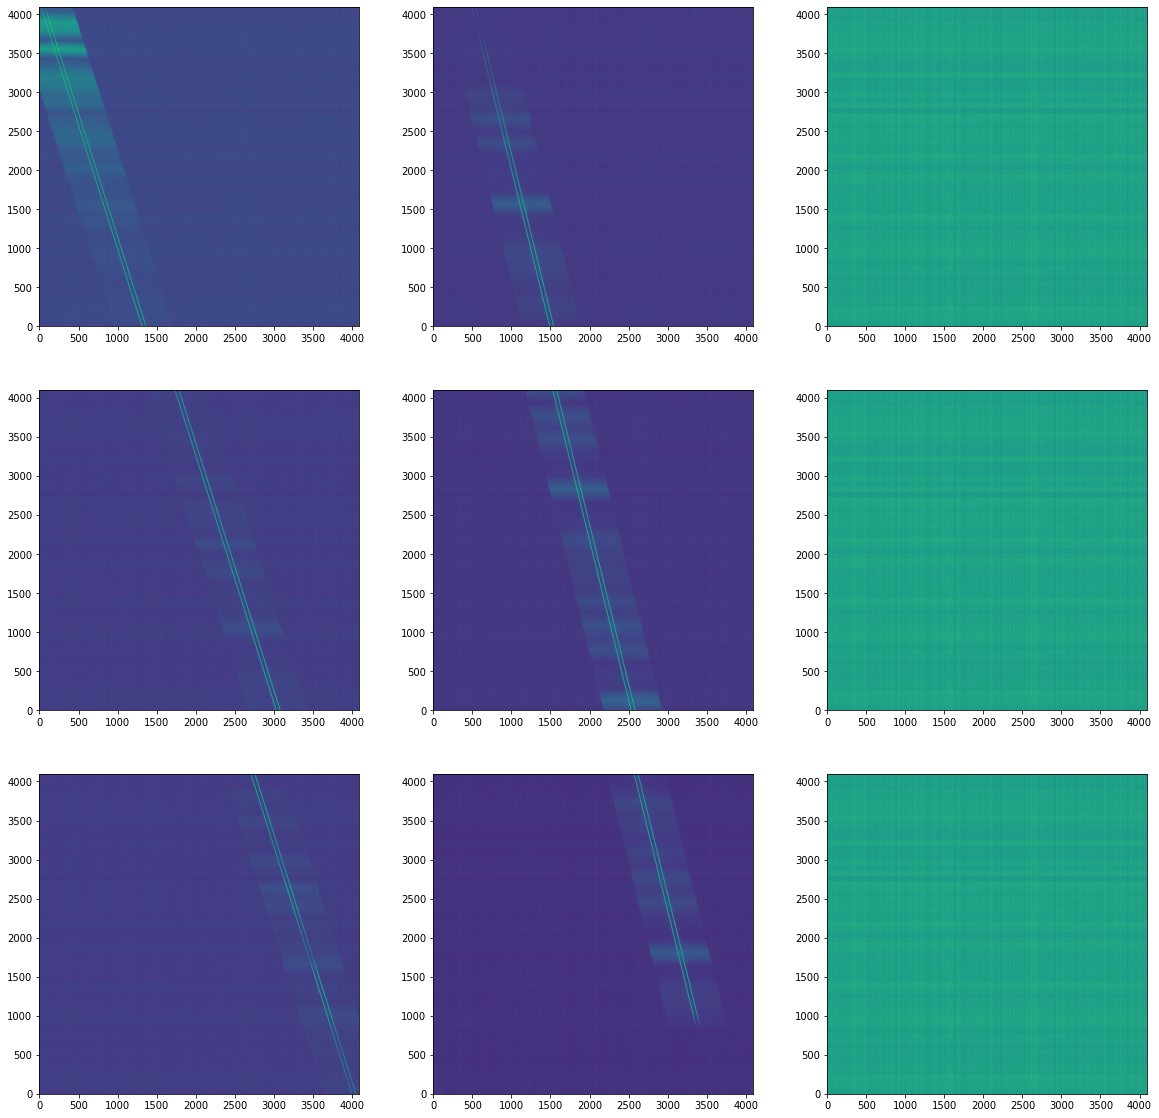

In [57]:
plt.figure(figsize=(20, 20))
for hdu_i, plot_i in zip([1,2,3,6,5,4,7,8,9], range(1, 10)):
    plt.subplot(3,3,plot_i)
    plt.imshow(hdus[0][hdu_i].data, origin="lower", norm=LogNorm())   